# ANNDL Challenge 1 code
Alessio Facincani        /        Mousa Sondoqah        /        Mohanad Diab

💻 This notebook is to be submitted, and contains the main code we used to produce our models, carefully polished, described, commented, and divided in different levels of headings, in order to exploit the **collapse** function of python notebooks and keep everything in order.

👉 **To build the final model, run all cells except those with [❌] in the heading**, which are present for the sake of completeness of our work. (Running them will still produce the same model, their output has no effect on the subsequent code, but they just take long to compute.)

## Import libs and dataset
These cells import all the required libraries and downloads the dataset from a public link

In [ ]:
# !pip install -U d2l
#from __future__ import absolute_import, division, print_function, unicode_literals # legacy compatibility

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors # to colorfully plot common diagram
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
# from d2l import tensorflow as d2l
# from tensorflow.keras.callbacks import CSVLogger #to save history in file
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
tfk = tf.keras
tfkl = tf.keras.layers

from IPython.display import clear_output
clear_output()

print("> Phyical GPU list:")
print(tf.config.list_physical_devices('GPU'))
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

> Phyical GPU list:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Mon Nov 28 20:25:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
 

In [ ]:
# reproducibility
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
# structure
input_shape = (96, 96, 3)
epochs = 200

In [ ]:
!wget 'https://github.com/TheFacc/ANNDL/blob/master/training_dataset_homework1.zip?raw=true'
# unzip the dataset twice:
!unzip '/content/training_dataset_homework1.zip?raw=true' -d '/content/trOrig/' # just original dataset
!unzip '/content/training_dataset_homework1.zip?raw=true' -d '/content/trAug/' # here we will add more data later by augmentation
dataset_dir_aug = "/content/trAug/training_data_final"
dataset_dir = "/content/trOrig/training_data_final"
clear_output()

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name, patience):
  exps_dir = os.path.join('data_augmentation_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=True, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=patience, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

## Preprocessing
Augmentation on the dataset

### Standard augmentation
Apply basic augmentation for a more generalized training.

Saves the split dataset in the variables `train_gen`, and `valid_gen` (not augmented, just rescaled) for later use.

Split dataset in train/validation (80/20) with the ImageDataGenerator's `subset` parameter. By setting `shuffle=False` we can ensure that the augmented training data split is complementary to the un-augmented validation data split.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create an instance of ImageDataGenerator for training, validation, and test sets
train_data_gen = ImageDataGenerator(validation_split = .2, # sacrifice some training data in order to get a validation set
                                    rescale=1/255.,
                                    # rotation_range=20,
                                    # width_shift_range=0.1,
                                    # height_shift_range=0.1,
                                    # shear_range=0.1,
                                    # zoom_range=[1, 1.2],
                                    brightness_range=[.2, 1.2],
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    # fill_mode='reflect',
                                    # preprocessing_function = myPreproc,
                                    )
valid_data_gen = ImageDataGenerator(rescale=1/255.)

# Obtain a data generator
# train_gen_aug = train_data_gen.flow_from_directory(directory=dataset_dir_aug, #train on augmented data (with more files for some species)[deprecated]
#                                                target_size=(96,96),
#                                                color_mode='rgb',
#                                                classes=None, # can be set to labels
#                                                class_mode='categorical',
#                                                batch_size=8,
#                                                shuffle=False,
#                                                subset='training',
#                                                seed=seed)
train_gen = train_data_gen.flow_from_directory(directory=dataset_dir, # train on augmented data
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               subset='training',
                                               seed=seed)
valid_gen = valid_data_gen.flow_from_directory(directory=dataset_dir, #validation only on original data
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               subset='validation',
                                               seed=seed)

Found 2836 images belonging to 8 classes.
Found 0 images belonging to 8 classes.


### Weighing species
Apply different weights to different species to overcome the issue of unbalanced data files available.

In [ ]:
speciesCount=[]
for i in range(8):
  file_count = sum(len(files) for _, _, files in os.walk(dataset_dir+'/Species'+str(i+1)))
  speciesCount.append(file_count)

sumc=0
for num in speciesCount:
  sumc=sumc+num
avg=sumc/8

class_weights={}
for i in range(len(speciesCount)):
  class_weights[i]=avg/speciesCount[i]

### [❌ deprecated] Create additional files for species with fewer data
Increase file count for species 1,6 via basic augmentation, save the improved dataset to `dataset_dir_aug` folder

In [ ]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

filegen = ImageDataGenerator(#rotation_range=10,
                            #  width_shift_range=0.1,
                            #  height_shift_range=0.1,
                            #  shear_range=0.1,
                            #  zoom_range=[1, 1.2],
                             horizontal_flip=True,
                             vertical_flip=True,
                             brightness_range=[.2, 1.2],
                             fill_mode="reflect")

dirs = [dataset_dir_aug+"/Species1/",
        # dataset_dir_aug+"/Species2/",
        # dataset_dir_aug+"/Species4/",
        dataset_dir_aug+"/Species6/",
        # dataset_dir_aug+"/Species8/",
        ]
        
for dir in dirs:
  for filename in os.listdir(dir):
      f = os.path.join(dir, filename)
      if os.path.isfile(f):
          img = load_img(f)
          print(f)
          x = img_to_array(img) # (3,96,96)
          x = x.reshape((1,) + x.shape) # (1,3,96,96)
          # generate Nc transformed copies of each img
          Nc = 2
          i = 1
          for batch in filegen.flow(x, batch_size=1, save_to_dir=dir, save_prefix="aug", save_format="jpg"):
            i+=1
            if i>Nc:
              break
clear_output()

### [❌ failed] Custom augmentation: playing with Color Space (`CS`)
These cells take the original data files, convert them all to a different CS and export in a different folder.

Saves the split dataset in the variables `train_gen_cs` and `valid_gen_cs` for later use.

#### ❌ Convert all RGB images from `dataset_dir` (`trOrig`) and save files to `trCS` folder

Libs and custom functions definitions

In [ ]:
from skimage import data
from skimage.color import convert_colorspace
from skimage.io import imread

colspace = 'C1C2C3' # RGB, HSV, YUV, XYZ, I1I2I3, C1C2C3

if not os.path.exists('/content/trCS/'):
    os.mkdir('/content/trCS/')
dataset_dir_cs = '/content/trCS'
# labels = list(train_gen.class_indices)
labels = ['Species1', 'Species2', 'Species3', 'Species4', 'Species5', 'Species6', 'Species7', 'Species8']

def RGBtoC1C2C3(RR,GG,BB):
  # convert from RGB to C1C2C3 color space
  # ncols = RR.shape[0]
  # nrows = RR.shape[1]
  # C1 = C2 = C3 = np.zeros((nrows,ncols))
  # for i in range(nrows):
  #   for j in range(ncols):
  #     C1[i][j] = ((np.arctan( RR[i,j] / max(GG[i,j],BB[i,j],1) )) + np.pi/2 )/np.pi
  #     C2[i][j] = ((np.arctan( GG[i,j] / max(BB[i,j],RR[i,j],1) )) + np.pi/2 )/np.pi
  #     C3[i][j] = ((np.arctan( BB[i,j] / max(RR[i,j],GG[i,j],1) )) + np.pi/2 )/np.pi
  # return np.dstack((C1,C2,C3))
  im = np.dstack((RR,GG,BB)).astype(np.float32)+0.001 #to avoid division by 0
  return np.arctan(im/np.dstack((cv2.max(im[...,1], im[...,2]), cv2.max(im[...,0], im[...,2]), cv2.max(im[...,0], im[...,1]))))

def RGBtoI1I2I3(RR,GG,BB):
  # convert from RGB to I1I2I3 color space
  # D1 = (RR-GG)**2
  # D2 = (GG-BB)**2
  # D3 = (BB-RR)**2
  # den = D1+D2+D3
  # img_cs[:,:,0] = D1/den #(R+G+B)/3
  # img_cs[:,:,1] = D3/den #(R-B)/2
  # img_cs[:,:,2] = D2/den #(2*G-R-B)/4
  # return np.dstack((D1/den,D2/den,D3/den))
  return np.dstack(((R+G+B)/3, (R-B)/2, (2*G-R-B)/4))

Conversion

In [ ]:
for i in range(len(labels)):
    print(f"Converting {labels[i]}...")
    curLabelDir = '{}/{}/'.format(dataset_dir, labels[i]) #source
    outLabelDir = f'/content/trCS/{labels[i]}/' #destination
    if not os.path.exists(outLabelDir):
        os.mkdir(outLabelDir)
    class_imgs = next(os.walk(curLabelDir))[2]
    for class_img in class_imgs:
        img = imread('{}/{}/{}'.format(dataset_dir, labels[i], class_img))
        # convert it
        if colspace:
            if colspace=='YUV' or colspace=='HSV' or colspace=='XYZ':
                img_cs = convert_colorspace(img, 'RGB', colspace)
            else: # manually convert color space
                img_cs = img
                R = img[:,:,0]
                G = img[:,:,1]
                B = img[:,:,2]
                if colspace=='I1I2I3': # this CS should be invariant to highlight effects
                    img_cs = RGBtoI1I2I3(R,G,B)
                elif colspace=='C1C2C3': # this CS should be invariant to shadowing
                    img_cs = RGBtoC1C2C3(R,G,B)
                else:
                    print("Invalid color space: ",colspace)
                    break
            # save
            plt.imsave(f'{outLabelDir}/cs_{class_img}', img_cs)
        else:
            print("Color space not defined!")
            break
print("Finished!")

#delete:
# import shutil
# shutil.rmtree(r'/content/trCS/')

Converting Species1...
Converting Species2...
Converting Species3...
Converting Species4...
Converting Species5...
Converting Species6...
Converting Species7...
Converting Species8...
Finished!


In [ ]:
# # zip and download to see
# from google.colab import drive
# drive.mount('/content/gdrive')
# !zip -r /content/gdrive/Shareddrives/rw/trCS_I1I2I3_notnorm.zip /content/trCS/
# clear_output()
# print("** Finished! **")

** Finished! **


#### ❌ Plot one example for each species

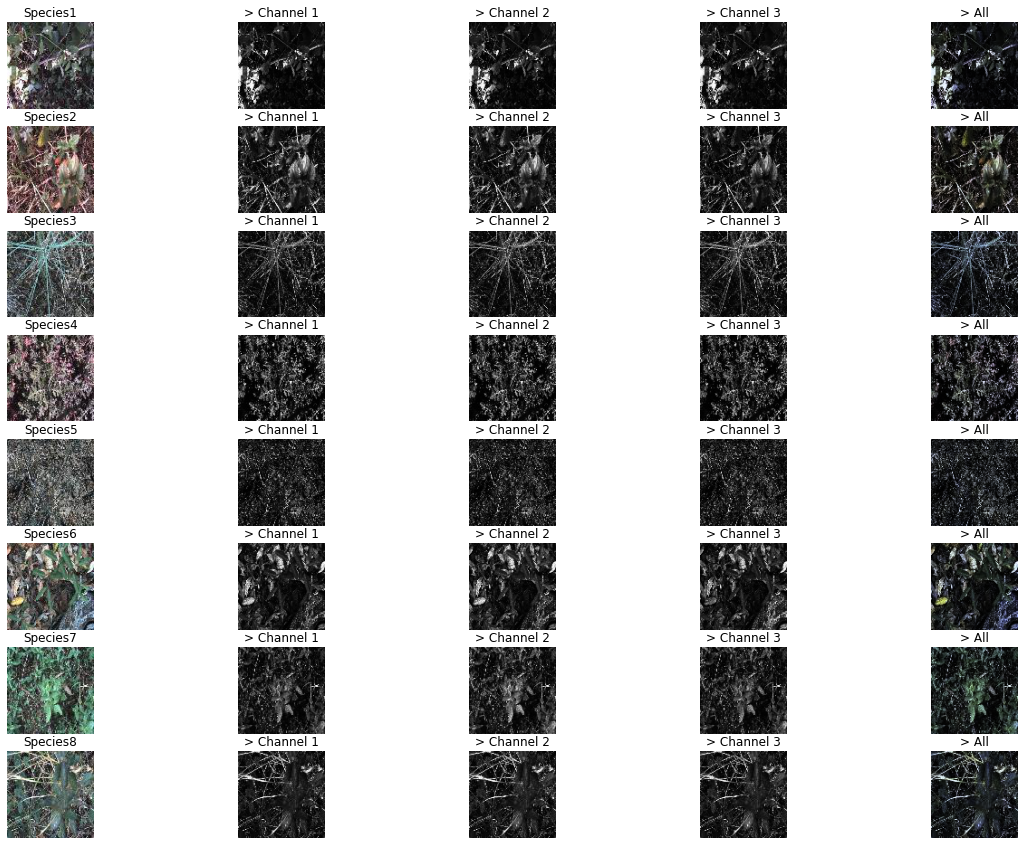

In [ ]:
num_col = 5 # orig, c1,c2,c3, allC
fig, axes = plt.subplots(len(labels), num_col, figsize=(20, 15), sharex=True, sharey=True)
for i in range(len(labels)):
    # get the first image in folder and plot
    curLabelDir = '{}/{}/'.format(dataset_dir, labels[i])
    class_img = next(os.walk(curLabelDir))[2][0]
    img = imread('{}/{}/{}'.format(dataset_dir, labels[i], class_img))
    axes[i][0].imshow(np.array(img));
    axes[i][0].set_title('{}'.format(labels[i]))
    # convert it
    if colspace:
        if colspace=='YUV' or colspace=='HSV' or colspace=='XYZ':
            img_cs = convert_colorspace(img, 'RGB', colspace)
        else: # manually convert color space
            img_cs = img
            R = img[:,:,0]
            G = img[:,:,1]
            B = img[:,:,2]
            if colspace=='I1I2I3': # should be invariant to highlight effects
                img_cs = RGBtoI1I2I3(R,G,B)
            elif colspace=='C1C2C3': # should be invariant to shadowing
                img_cs = RGBtoC1C2C3(R,G,B)
            else:
                print("Invalid color space: ",colspace)
                break
        # ax = axes.ravel()
        axes[i][1].imshow(np.array(img_cs[:,:,0]), cmap='gray'); axes[i][1].set_title('> Channel 1')
        axes[i][2].imshow(np.array(img_cs[:,:,1]), cmap='gray'); axes[i][2].set_title('> Channel 2')
        axes[i][3].imshow(np.array(img_cs[:,:,2]), cmap='gray'); axes[i][3].set_title('> Channel 3')
        axes[i][4].imshow(np.array(img_cs));                     axes[i][4].set_title('> All')
    else:
        print("Color space not defined!")
        break

for a in axes.ravel():
    a.axis('off')
# fig.tight_layout()

#### ❌ Split dataset for training

In [ ]:
# dataset_dir_cs = '/content/trCS'

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create an instance of ImageDataGenerator for training, validation, and test sets
train_data_gen_cs = ImageDataGenerator(validation_split = .2, # sacrifice some training data in order to get a validation set
                                    rescale=1/255.,
                                    # rotation_range=20,
                                    # width_shift_range=0.1,
                                    # height_shift_range=0.1,
                                    # shear_range=0.1,
                                    # zoom_range=[1, 1.2],
                                    # brightness_range=[1, 1.2],
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    # fill_mode='reflect',
                                    )
# valid_data_gen = ImageDataGenerator()

# Obtain a data generator
train_gen_cs = train_data_gen_cs.flow_from_directory(directory=dataset_dir_cs, #train on augmented data
                                               target_size=(96,96),
                                               color_mode='rgb', #yuppp
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=True,
                                               subset='training',
                                               seed=seed)
valid_gen_cs = train_data_gen_cs.flow_from_directory(directory=dataset_dir_cs, #validation only on original data
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               subset='validation',
                                               seed=seed)

Found 2836 images belonging to 8 classes.
Found 706 images belonging to 8 classes.


## View data samples

In [ ]:
labels = list(train_gen.class_indices)
print("Assigned labels")
print(labels)
print()
print("Target classes")
print(train_gen.classes)

Assigned labels
['Species1', 'Species2', 'Species3', 'Species4', 'Species5', 'Species6', 'Species7', 'Species8']

Target classes
[0 0 0 ... 7 7 7]


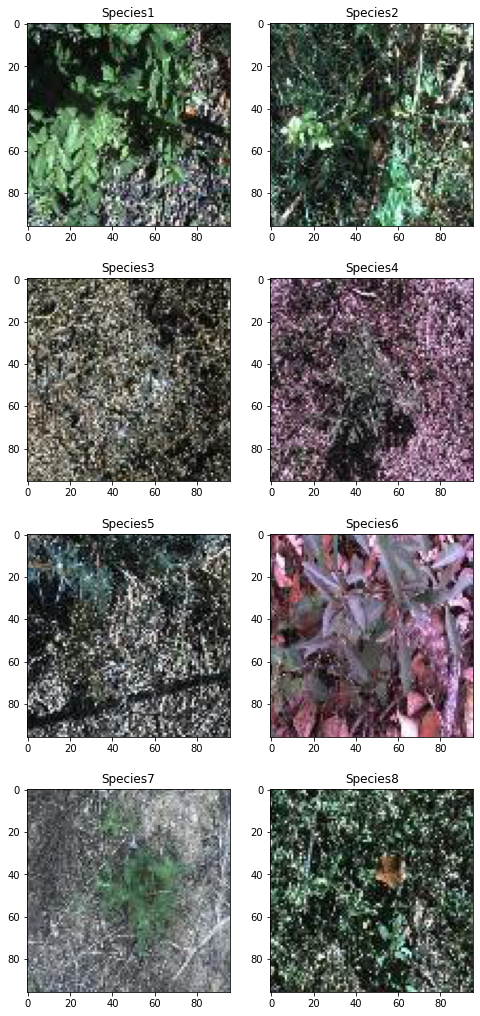

In [ ]:
num_row = 4
num_col = 2
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,9*num_col))
for i in range(num_row*num_col):
  if i < len(labels):
    class_imgs = next(os.walk('{}/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
# plt.tight_layout()
plt.show()

## NN

### **MODEL**:
Run only ONE of these cells, based on the model you want to use (each model has a brief comment on its performance, last is best)

#### Model 0: load file

In [ ]:
# load model
# from google.colab import drive
# drive.mount('/content/gdrive')

# !unzip /content/gdrive/Shareddrives/rw/model_d201_longtrain5_noft_aug_valreal_9492_lr6allreal_9693.zip -d /content/LoadedModel
# model = tf.keras.models.load_model('/content/LoadedModel/SubmissionModel/')
# print("Model loaded!\n")
# model.summary()

Model loaded!

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 3, 3, 1920)        18321984  
                                                                 
 global_max_pooling2d (Globa  (None, 1920)             0         
 lMaxPooling2D)                                                  
                                                                 
 batch_normalization (BatchN  (None, 1920)             7680      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1024)              1967104   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 batch_normalization_1 (Batc  (None, 1024

#### ❌ Model 1: Lab4

In [ ]:
def build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    conv1 = tfkl.Conv2D(
        filters=32,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(input_layer)
    pool1 = tfkl.MaxPooling2D()(conv1)

    conv2 = tfkl.Conv2D(
        filters=64,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool1)
    pool2 = tfkl.MaxPooling2D()(conv2)

    conv3 = tfkl.Conv2D(
        filters=128,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D()(conv3)

    conv4 = tfkl.Conv2D(
        filters=256,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool3)
    pool4 = tfkl.MaxPooling2D()(conv4)

    conv5 = tfkl.Conv2D(
        filters=512,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool4)
    pool5 = tfkl.MaxPooling2D()(conv5)

    flattening_layer = tfkl.Flatten(name='Flatten')(pool5)
    dropout = tfkl.Dropout(0.3, seed=seed)(flattening_layer)
    classifier_layer = tfkl.Dense(units=512, name='Classifier', kernel_initializer=tfk.initializers.HeUniform(seed), activation='relu')(dropout)
    dropout = tfkl.Dropout(0.3, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(dropout)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

#### ❌ Model 2: Custom CNN

In [ ]:
def build_model(input_shape):

    data_augmentation = True
    dropout = True

    model = models.Sequential()
    if data_augmentation:
        model.add(tfkl.experimental.preprocessing.RandomFlip("horizontal", input_shape=input_shape))
        model.add(tfkl.experimental.preprocessing.RandomRotation(0.2))
        model.add(tfkl.experimental.preprocessing.RandomZoom(0.1))
    model.add(tfkl.Conv2D(128, (3,3), padding='same', input_shape=input_shape))
    model.add(tfkl.Conv2D(128, (3, 3), padding='same'))
    model.add(tfkl.MaxPooling2D((2, 2)))
    if dropout:
        model.add(tfkl.Dropout(0.05))

    model.add(tfkl.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(tfkl.MaxPooling2D((2, 2)))
    if dropout:
        model.add(tfkl.Dropout(0.05))

    model.add(tfkl.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(tfkl.Conv2D(256, (3, 3), activation='relu'))
    model.add(tfkl.MaxPooling2D((2, 2)))
    if dropout:
        model.add(tfkl.Dropout(0.05))

    model.add(tfkl.Flatten())
    model.add(tfkl.Dense(1024, activation='relu')) #4096
    if dropout:
        model.add(tfkl.Dropout(0.05))
    model.add(tfkl.Dense(1024, activation='relu'))
    if dropout:
        model.add(tfkl.Dropout(0.05))
    model.add(tfkl.Dense(8, activation='softmax'))
    if dropout:
        model.add(tfkl.Dropout(0.05))

    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    return model

#### ❌ Model 3: AlexNet-like

In [ ]:
def build_model(input_shape):
    #AlexNet-like model
    model = models.Sequential()
    model.add(tfkl.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=input_shape))

    model.add(tfkl.Conv2D(96, 11, strides=4, activation='relu', padding='same'))
    model.add(tfkl.BatchNormalization())
    model.add(tfkl.MaxPooling2D(3, strides=2))

    model.add(tfkl.Conv2D(256, 5, strides=4, activation='relu', padding='same'))
    model.add(tfkl.BatchNormalization())
    model.add(tfkl.MaxPooling2D(3, strides=2))

    model.add(tfkl.Conv2D(384, 3, strides=4, activation='relu', padding='same'))
    model.add(tfkl.BatchNormalization())
    model.add(tfkl.Conv2D(384, 3, strides=4, activation='relu', padding='same'))
    model.add(tfkl.BatchNormalization())
    model.add(tfkl.Conv2D(256, 3, strides=4, activation='relu', padding='same'))
    model.add(tfkl.BatchNormalization())
    model.add(tfkl.MaxPooling2D(3, strides=2)) ##
    model.add(tfkl.Flatten())
    model.add(tfkl.Dense(1024, activation='relu')) #4096
    model.add(tfkl.Dropout(0.5))
    model.add(tfkl.Dense(256, activation='relu')) #4096
    model.add(tfkl.Dropout(0.5))
    model.add(tfkl.Dense(8, activation='softmax'))

    return model

#### ❌ Model 4: TL-VGG16

In [ ]:
def build_model(input_shape):
    # transfer learning: import VGG16 and freeze it
    supernet = tfk.applications.VGG16(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling=max,
    )
    supernet.trainable = False

    model = models.Sequential()
    model.add(supernet)
    model.add(tfkl.Flatten())
    model.add(tfkl.Dense(2048, activation='relu'))
    model.add(tfkl.Dropout(0.3))
    model.add(tfkl.Dense(512, activation='relu'))
    model.add(tfkl.Dropout(0.2))
    model.add(tfkl.Dense(8, activation='softmax'))
    
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    return model

#### ❌ Model 5: TL-Xception
plain bad

In [ ]:
def build_model(input_shape):
    # transfer learning: import Xception(2017) and freeze it
    xcepnet = tfk.applications.Xception(
        include_top=False,
        weights="imagenet",
        # input_tensor=None,
        input_shape=input_shape,
        pooling=max,
        classes=8,
        classifier_activation="softmax",
    )
    xcepnet.trainable = False

    model = models.Sequential()
    model.add(xcepnet)
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(8, activation='softmax'))

    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    return model

#### ❌ Model 6: DenseNet121


In [ ]:
def build_model(input_shape):
    # transfer learning
    supernet = tfk.applications.DenseNet121(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        # pooling=max,
    )
    # supernet.trainable = False

    # net
    model = models.Sequential()
    # tf.keras.layers.RandomContrast(.2, seed=seed) # only active during training
    model.add(supernet)
    model.add(tfkl.GlobalMaxPooling2D())
    model.add(tfkl.BatchNormalization())

    model.add(tfkl.Dense(1024, activation='relu'))
    model.add(tfkl.Dropout(0.5, seed=seed))
    model.add(tfkl.BatchNormalization())

    model.add(tfkl.Dense(256, activation='relu'))
    model.add(tfkl.Dropout(0.3, seed=seed))

    model.add(tfkl.Dense(8, activation='softmax'))
    # model.add(tfkl.Flatten())
    # tf.keras.layers.Dense(8, activation=None), # [TRIPLET] No activation on final dense layer
    # tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # [TRIPLET] L2 normalize embeddings

    return model

#### ✔ Model 7: TL-DenseNet201

In [ ]:
def build_model(input_shape):
    # transfer learning
    supernet = tfk.applications.DenseNet201(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        # pooling=max,
    )
    supernet.trainable = False # freeze it

    # net
    model = models.Sequential()
    
    model.add(supernet)
    model.add(tfkl.GlobalMaxPooling2D())
    model.add(tfkl.BatchNormalization())

    model.add(tfkl.Dense(1024, activation='relu'))
    model.add(tfkl.Dropout(0.5, seed=seed))
    model.add(tfkl.BatchNormalization())

    model.add(tfkl.Dense(512, activation='relu'))
    model.add(tfkl.Dropout(0.5, seed=seed))

    model.add(tfkl.Dense(8, activation='softmax'))
    # model.add(tfkl.Flatten())
    # tfkl.Dense(8, activation=None), # [TRIPLET] No activation on final dense layer
    # tfkl.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # [TRIPLET] L2 normalize embeddings

    return model

### **TRAINING**:

Build:

In [ ]:
# standard loss
model = build_model(input_shape)
model.summary()
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=1e-4), metrics='accuracy')

# triplet loss
# !pip install -q -U tensorflow-addons
# import tensorflow_addons as tfa
# model = build_model(input_shape)
# model.compile(loss=tfa.losses.TripletSemiHardLoss(), optimizer=tf.keras.optimizers.Adam(1e-3)) #[TRIPLET]

74836368/74836368 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 3, 3, 1920)        18321984  
                                                                 
 global_max_pooling2d (Globa  (None, 1920)             0         
 lMaxPooling2D)                                                  
                                                                 
 batch_normalization (BatchN  (None, 1920)             7680      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1024)              1967104   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                         

Train:

In [ ]:
# Freeze first N layers
nLayersToFreeze = 1
model.trainable = True
for i, layer in enumerate(model.layers[:nLayersToFreeze]):
  layer.trainable = False
print("FROZEN:\n[...]")
for i, layer in enumerate(model.layers):
  if i>max(-1,nLayersToFreeze-4):
    if i==nLayersToFreeze:
      print("\nTO TRAIN:")
    print(i, layer.name, " ==> Trainable" if layer.trainable else " -> FROZEN")

FROZEN:
[...]
0 densenet201  -> FROZEN

TO TRAIN:
1 global_max_pooling2d  ==> Trainable
2 batch_normalization  ==> Trainable
3 dense  ==> Trainable
4 dropout  ==> Trainable
5 batch_normalization_1  ==> Trainable
6 dense_1  ==> Trainable
7 dropout_1  ==> Trainable
8 dense_2  ==> Trainable


In [ ]:
callbacks = create_folders_and_callbacks(model_name='CNN_model', patience=15)
history = model.fit(x = train_gen,
                    validation_data = valid_gen, # using validation_split in ImageDataGenerator call
                    epochs = epochs,
                    callbacks = callbacks,
                    class_weight=class_weights,
                    ).history 
          
# Save model
model.save('D201_long5')
print('Model saved.')

Epoch 1/200
698/698 [==============================] - 123s 130ms/step - loss: 0.6386 - accuracy: 0.8176 - val_loss: 0.4446 - val_accuracy: 0.8768
Epoch 2/200
698/698 [==============================] - 84s 121ms/step - loss: 0.5990 - accuracy: 0.8271 - val_loss: 0.4540 - val_accuracy: 0.8824
Epoch 3/200
698/698 [==============================] - 83s 119ms/step - loss: 0.5001 - accuracy: 0.8504 - val_loss: 0.4570 - val_accuracy: 0.8839
Epoch 4/200
698/698 [==============================] - 84s 121ms/step - loss: 0.4915 - accuracy: 0.8547 - val_loss: 0.4449 - val_accuracy: 0.8938
Epoch 5/200
698/698 [==============================] - 86s 123ms/step - loss: 0.4575 - accuracy: 0.8575 - val_loss: 0.4080 - val_accuracy: 0.8966
Epoch 6/200
698/698 [==============================] - 83s 119ms/step - loss: 0.4470 - accuracy: 0.8609 - val_loss: 0.3765 - val_accuracy: 0.9065
Epoch 7/200
698/698 [==============================] - 84s 120ms/step - loss: 0.4021 - accuracy: 0.8746 - val_loss: 0.4110 

Model saved


#### FineTuning:

Unfreeze the network and train it slowly

In [ ]:
# Freeze first N layers
nLayersToFreeze = 0
model.trainable = True
for i, layer in enumerate(model.layers[:nLayersToFreeze]):
  layer.trainable = False
print("FROZEN:\n[...]")
for i, layer in enumerate(model.layers):
  if i>max(-1,nLayersToFreeze-4):
    if i==nLayersToFreeze:
      print("\nTO TRAIN:")
    print(i, layer.name, " ==> Trainable" if layer.trainable else " -> FROZEN")

FROZEN:
[...]

TO TRAIN:
0 densenet201  ==> Trainable
1 global_max_pooling2d  ==> Trainable
2 batch_normalization  ==> Trainable
3 dense  ==> Trainable
4 dropout  ==> Trainable
5 batch_normalization_1  ==> Trainable
6 dense_1  ==> Trainable
7 dropout_1  ==> Trainable
8 dense_2  ==> Trainable


In [ ]:
# continue training the model
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=1e-6), metrics='accuracy')
callbacks = create_folders_and_callbacks(model_name='CNN_model_TL', patience=15)
history_tl = model.fit(x = train_gen,
                       validation_data = valid_gen,
                       epochs = epochs,
                       callbacks = callbacks,
                       class_weight=class_weights,
                       ).history

Epoch 1/200
631/631 [==============================] - 57s 61ms/step - loss: 0.5311 - accuracy: 0.9267 - val_loss: 0.3841 - val_accuracy: 0.9278
Epoch 2/200
631/631 [==============================] - 34s 54ms/step - loss: 0.4608 - accuracy: 0.9362 - val_loss: 0.3629 - val_accuracy: 0.9306
Epoch 3/200
631/631 [==============================] - 33s 52ms/step - loss: 0.4134 - accuracy: 0.9394 - val_loss: 0.3241 - val_accuracy: 0.9292
Epoch 4/200
631/631 [==============================] - 31s 49ms/step - loss: 0.3698 - accuracy: 0.9457 - val_loss: 0.3567 - val_accuracy: 0.9306
Epoch 5/200
631/631 [==============================] - 34s 53ms/step - loss: 0.3366 - accuracy: 0.9501 - val_loss: 0.4357 - val_accuracy: 0.9263
Epoch 6/200
631/631 [==============================] - 31s 50ms/step - loss: 0.2538 - accuracy: 0.9574 - val_loss: 0.3461 - val_accuracy: 0.9363
Epoch 7/200
631/631 [==============================] - 33s 53ms/step - loss: 0.2376 - accuracy: 0.9608 - val_loss: 0.3974 - val_ac

## Test results

Confusion matrix

Found 3542 images belonging to 8 classes.
443/443 [==============================] - 19s 43ms/step - loss: 0.0681 - accuracy: 0.9842
SCORES:  [0.06806765496730804, 0.9841897487640381]

CONFUSION MATRIX (VALIDATION DATA): 
89/89 [==============================] - 6s 34ms/step


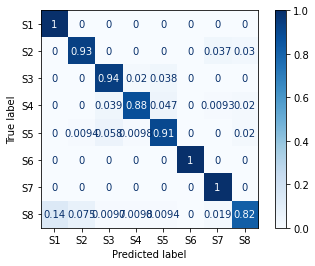


CONFUSION MATRIX (ALL DATA): 
443/443 [==============================] - 15s 34ms/step


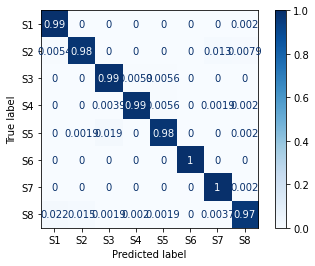

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
# from sklearn.model_selection import StratifiedKFold

# Y_pred = model.predict(valid_gen)#, num_of_test_samples // batch_size+1)
# y_pred = np.argmax(Y_pred, axis=1)
# print('Confusion Matrix')
# print(confusion_matrix(valid_gen.classes, y_pred))

#TEST on all data, just to see
testgen = ImageDataGenerator(rescale=1/255.)
testflow = testgen.flow_from_directory(directory=dataset_dir, #dataset_dir_aug
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False, #!
                                               seed=seed)
scores = model.evaluate(testflow)
print("SCORES: ",scores)

print("\nCONFUSION MATRIX (VALIDATION DATA): ")
predictions = model.predict(valid_gen)
Y_pred=np.argmax(predictions, axis=1)
y_pred = np.rint(Y_pred)
y_true = valid_gen.classes
cm = confusion_matrix(y_true, y_pred)
cm = cm / cm.astype(float).sum(axis=1) #normalization
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['S1','S2','S3','S4','S5','S6','S7','S8'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

print("\nCONFUSION MATRIX (ALL DATA): ")
predictions = model.predict(testflow)
Y_pred=np.argmax(predictions, axis=1)
y_pred = np.rint(Y_pred)
y_true = testflow.classes
cm = confusion_matrix(y_true, y_pred)
cm = cm / cm.astype(float).sum(axis=1) #normalization
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['S1','S2','S3','S4','S5','S6','S7','S8'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

## Save and export

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# Set output path and name
# filename = "mousa84_freelr6_8986_lr5_98899.zip"  --> SET MANUALLY IN !ZIP COMMAND
dir = "SubmissionModel" # *also* set manually in !ZIP

# save model files to {dir}
print("** Saving model... **")
model.save(f"/content/{dir}",save_format='tf')

# keep trace of which model is this (optional)
print("** Logging... **")
logname = f'/content/{dir}/model_summary_' + datetime.now().strftime('%b%d_%H-%M-%S') + '.txt'
with open(logname, mode='w') as f:
  model.summary(print_fn = lambda x: f.write(x + '\n'))
  f.close()

# zip it all for download
print("** Zipping... **")
!zip -r /content/gdrive/Shareddrives/rw/model_d201_longtrain5_noft_aug_valreal_9492_lr6allreal_9693.zip /content/SubmissionModel
print("** Finished! **")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
** Saving model... **


** Logging... **
** Zipping... **
  adding: content/SubmissionModel/ (stored 0%)
  adding: content/SubmissionModel/model_summary_Nov25_21-14-06.txt (deflated 80%)
  adding: content/SubmissionModel/assets/ (stored 0%)
  adding: content/SubmissionModel/variables/ (stored 0%)
  adding: content/SubmissionModel/variables/variables.index (deflated 80%)
  adding: content/SubmissionModel/variables/variables.data-00000-of-00001 (deflated 15%)
  adding: content/SubmissionModel/keras_metadata.pb (deflated 97%)
  adding: content/SubmissionModel/saved_model.pb (deflated 92%)
** Finished! **
